# K-Nearest Neighbors (KNN) - TensorFlow Implementation

Multi-class classification on the **Covertype (Forest Cover Type)** dataset using TensorFlow tensor operations.

**Dataset**: 581,012 samples, 54 features, 7 forest cover types  
**Task**: Predict forest cover type from cartographic variables  
**Key Concept**: KNN is a "lazy learner" - no training phase, expensive at prediction time

## TensorFlow Approach for KNN
- **Tensor operations**: Broadcasting for pairwise distance computation
- **`tf.math.top_k`**: Efficient K-nearest selection
- **Batched processing**: Memory management for large datasets

## Important Note: CPU-Only Execution
- TensorFlow 2.11+ dropped native Windows GPU support. This implementation runs on CPU.
- For GPU acceleration on Windows, options include WSL2 or TensorFlow 2.10 with Python ≤3.10.
- GPU setup will be configured when we reach neural network models (DNNs, CNNs).


In [1]:
# Standard libraries
import numpy as np
import sys

# TensorFlow for GPU-accelerated tensor operations
import tensorflow as tf

# Add utils to path
sys.path.append('../..')
from utils.data_loader import load_processed_data
from utils.metrics import accuracy, macro_f1_score
from utils.visualization import (
    plot_confusion_matrix_multiclass,
    plot_per_class_f1
)
from utils.performance import track_performance

# Check device
print(f"TensorFlow version: {tf.__version__}")
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPU available: {gpus[0].name}")
else:
    print("Running on CPU (TF 2.11+ dropped native Windows GPU support)")

print("Imports complete!")

TensorFlow version: 2.20.0
Running on CPU (TF 2.11+ dropped native Windows GPU support)
Imports complete!


In [2]:
# Load preprocessed Data
"""
Load the same Covertype dataset used by Scikit-learn, No-Framework, and PyTorch.
This ensures fair comparison across all 4 frameworks.
"""

X_train, X_test, y_train, y_test, metadata = load_processed_data('knn')

# Extract metadata for reference
class_names = metadata['class_names']
n_classes = metadata['n_classes']

print(f"Training set: {X_train.shape[0]:,} samples, {X_train.shape[1]} features")
print(f"Test set: {X_test.shape[0]:,} samples")
print(f"Classes ({n_classes}): {class_names}")

Training set: 464,809 samples, 54 features
Test set: 116,203 samples
Classes (7): ['Spruce/Fir', 'Lodgepole Pine', 'Ponderosa Pine', 'Cottonwood/Willow', 'Aspen', 'Douglas-fir', 'Krummholz']


In [3]:
# Convert Data to TensorFlow Tensors
"""
Convert NumPy arrays to TensorFlow constant tensors.
Unlike pytorch, tensorflow tensors are immutable by default (tf.constant).
Running on CPU since TF 2.11+ dropped native windows gpu support.
"""

# Convert to tensorflow tensors
# tf.constant creates immutable tensors (vs pytorchs mutable torch.tensor)
X_train_t = tf.constant(X_train, dtype=tf.float32)
X_test_t = tf.constant(X_test, dtype=tf.float32)
y_train_t = tf.constant(y_train, dtype=tf.int64)
y_test_t = tf.constant(y_test, dtype=tf.int64)

print(f"X_train tensor: {X_train_t.shape}, dtype={X_train_t.dtype}")
print(f"X_test tensor:  {X_test_t.shape}, dtype={X_test_t.dtype}")
print(f"Device: {X_train_t.device}")

X_train tensor: (464809, 54), dtype=<dtype: 'float32'>
X_test tensor:  (116203, 54), dtype=<dtype: 'float32'>
Device: /job:localhost/replica:0/task:0/device:CPU:0


In [4]:
# KNN Prediction Function (TensorFlow)
"""
TensorFlow KNN using tensor operations for distance computation.

Key differences from PyTorch:
    - No tf.cdist equivalent - use broadcasting for Manhattan distance
    - tf.math.top_k returns LARGEST by default (need to negate distances)
    - TensorFlow tensors are immutable - different memory patterns
    - Running on CPU (TF 2.11+ dropped native Windows GPU support)
    - Must chunk along training axis to avoid OOM (no optimized kernel like torch.cdist)

Memory consideration:
    Broadcasting creates a 3D intermediate: (batch_size, n_train, n_features)
    With full X_train: 500 x 464,809 x 54 x 4 bytes = ~50 GB (will crash!)
    Chunked: 500 x 5,000 x 54 x 4 bytes = ~540 MB per chunk (manageable)

Best hyperparameters (from Scikit-Learn GridSearchCV):
    - K=3, Manhattan distance (p=1), distance-weighted voting
"""

def manhattan_distance_chunked(batch, X_train, train_chunk_size=5000):
    """
    Memory-efficient manhattan distance by chunking along the training axis.

    Without chunking, broadcasting creates a (batch_size, 464809, 54) tensor which requires ~50-200 GB depending on batch_size.
    By processing X_train in chunks, peak memory stays under ~540 MB per chunk.

    Args:
        batch: test samples (batch_size, n_features)
        X_train: training samples (n_train, n_features)
        train_chunk_size: number of training samples per chunk
    
    Returns:
        distance: (batch_size, n_train) manhattan distances
    """
    chunks = []
    for c_start in range(0, X_train.shape[0], train_chunk_size):
        c_end = min(c_start + train_chunk_size, X_train.shape[0])
        chunk = X_train[c_start:c_end]
        # Intermediate: (batch_size, chunk_size, 54) - much smaller
        diff = tf.abs(tf.expand_dims(batch, 1) - tf.expand_dims(chunk, 0))
        chunks.append(tf.reduce_sum(diff, axis=2))
    return tf.concat(chunks, axis=1)

def knn_predict_tf(X_train, y_train, X_test, k=3, batch_size=500, n_classes=7):
    """
    TensorFlow KNN prediction with manhattan distance and distance weighting.

    Args:
        - X_train: training features tensor (n_train, n_features)
        - y_train: training labels tensor (n_train,)
        - X_test: Test features tensor (n_test, n_features)
        - k: number of neighbors
        - batch_size: samples per batch (manages memory)
        - n_classes: number of classes for voting
    
    Returns:
        predictions: predicted class labels (n_test,)
    """
    n_test = X_test.shape[0]
    all_predictions = []

    for start_idx in range(0, n_test, batch_size):
        end_idx = min(start_idx + batch_size, n_test)
        batch = X_test[start_idx:end_idx]

        # Compute manhattan (L1) distances using chunked approahc
        distances = manhattan_distance_chunked(batch, X_train)

        # Find k nearest neighbors
        # tf.math.top_k returns largest values, so negate distances to get smallest
        neg_distances = tf.negative(distances)
        k_values, k_indices = tf.math.top_k(neg_distances, k=k)
        k_distances = tf.negative(k_values) # Convert back to positive distances

        # Get labels of K nearest neighbors
        k_labels = tf.gather(y_train, k_indices)    # shape: (batch_size, k)

        # Distance-weighted voting: weight = 1 / (distance + epsilon)
        epsilon = 1e-8
        weights = 1.0 / (k_distances + epsilon) # shape: (batch_size, k)

        # Accumulate weighted votes for each class
        # Labels are 1-indexed (1-7), subtract 1 for array indexing (0-6)
        batch_preds = []
        for i in range(end_idx - start_idx):
            class_weights = tf.zeros(n_classes)
            for j in range(k):
                class_idx = k_labels[i, j] - 1 
                # tf.tensor_scatter_nd_update to add weight at class index
                class_weights = class_weights + tf.one_hot(class_idx, n_classes) * weights[i, j]
            batch_preds.append(tf.argmax(class_weights) + 1)
        
        all_predictions.extend(batch_preds)
    
    return tf.cast(tf.stack(all_predictions), dtype=tf.int64)

print("KNN prediction function defined (TensorFlow)")
print(f"Using: K=3, Manhattan distance, distance-weighted voting")
print(f"Chunked distance computation (train_chunk_size=5000, batch_size=500)")

KNN prediction function defined (TensorFlow)
Using: K=3, Manhattan distance, distance-weighted voting
Chunked distance computation (train_chunk_size=5000, batch_size=500)


In [5]:
"""
# Quick test to verify correctness on small subset
# Test on ~5% of test set before commiting to full run.
# This should take 5-10 minutes on cpu.


test_size = len(X_test_t) // 20  # ~5,810 samples
print(f"Quick test: {test_size:,} samples (5% of test set)")
print("-" * 40)

with track_performance() as perf:
    y_pred_small = knn_predict_tf(X_train_t, y_train_t, X_test_t[:test_size], k=3, batch_size=500, n_classes=n_classes)

# Check accuracy on subset
y_pred_small_np = y_pred_small.numpy()
small_acc = accuracy(y_test[:test_size], y_pred_small_np)

print(f"\nTime: {perf['time']:.2f} seconds")
print(f"Peak memory: {perf['memory']:.2f} MB")
print(f"Accuracy on subset: {small_acc:.4f}")
print(f"Throughput: {test_size / perf['time']:,.0f} samples/second")
print(f"\nEstimated full run: {perf['time'] * 20 / 60:.0f} minutes")"""

'\n# Quick test to verify correctness on small subset\n# Test on ~5% of test set before commiting to full run.\n# This should take 5-10 minutes on cpu.\n\n\ntest_size = len(X_test_t) // 20  # ~5,810 samples\nprint(f"Quick test: {test_size:,} samples (5% of test set)")\nprint("-" * 40)\n\nwith track_performance() as perf:\n    y_pred_small = knn_predict_tf(X_train_t, y_train_t, X_test_t[:test_size], k=3, batch_size=500, n_classes=n_classes)\n\n# Check accuracy on subset\ny_pred_small_np = y_pred_small.numpy()\nsmall_acc = accuracy(y_test[:test_size], y_pred_small_np)\n\nprint(f"\nTime: {perf[\'time\']:.2f} seconds")\nprint(f"Peak memory: {perf[\'memory\']:.2f} MB")\nprint(f"Accuracy on subset: {small_acc:.4f}")\nprint(f"Throughput: {test_size / perf[\'time\']:,.0f} samples/second")\nprint(f"\nEstimated full run: {perf[\'time\'] * 20 / 60:.0f} minutes")'

In [6]:
# Run KNN prediction with performance tracking
"""
Run tensorflow knn prediction on the full test set (CPU).

Note: This will be significantly slower than pytorch gpu due to:
    1. cpu-only execution
    2. no tf.cdist equivalent (chunked broadcasting vs optimized cuda kernel)
    3. python-level loops for weighted voting
"""

# Run prediction with performance tracking
print("Running KNN prediction on test set (CPU)...")
print(f"Test samples: {X_test_t.shape[0]:,}")
print(f"Training samples: {X_train_t.shape[0]:,}")
print(f"Batch size: 500, Train chunk size: 5000")
print("-" * 40)

with track_performance() as perf:
    y_pred_t = knn_predict_tf(X_train_t, y_train_t, X_test_t, k=3, batch_size=500, n_classes=n_classes)

# Convert predictions to NumPy for metrics
y_pred = y_pred_t.numpy()

print(f"\nPrediction time: {perf['time']:.2f} seconds")
print(f"Peak memory: {perf['memory']:.2f} MB")
print(f"Throughput: {len(X_test) / perf['time']:,.0f} samples/second")

Running KNN prediction on test set (CPU)...
Test samples: 116,203
Training samples: 464,809
Batch size: 500, Train chunk size: 5000
----------------------------------------

Prediction time: 1055.34 seconds
Peak memory: 24.30 MB
Throughput: 110 samples/second


In [ ]:
# Model Evaluation
"""
Evaluate KNN prediction using the same metrics as all other frameworks:
    - Accuracy: Overall correct prediction
    - Macro F1: Average F1 across all 7 classes (treats each class equally)
    - Per-Class F1: Identify which forest types are hardest to classify
"""
# Calculate metrics
test_acc = accuracy(y_test, y_pred)
macro_f1, per_class_f1 = macro_f1_score(y_test, y_pred, return_per_class=True) # type: ignore

print("=" * 50)
print("FINAL MODEL PERFORMANCE (TensorFlow CPU)")
print("=" * 50)
print(f"Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"Macro F1 Score: {macro_f1:.4f}")
print()
print("Per-Class F1 Scores:")
print("-" * 30)
for name, f1 in zip(class_names, per_class_f1):
    print(f"  {name:<20}: {f1:.4f}")

FINAL MODEL PERFORMANCE (TensorFlow CPU)
Test Accuracy: 0.9377 (93.77%)
Macro F1 Score: 0.8935

Per-Class F1 Scores:
------------------------------
  Spruce/Fir          : 0.9386
  Lodgepole Pine      : 0.9481
  Ponderosa Pine      : 0.9199
  Cottonwood/Willow   : 0.8136
  Aspen               : 0.8276
  Douglas-fir         : 0.8566
  Krummholz           : 0.9501


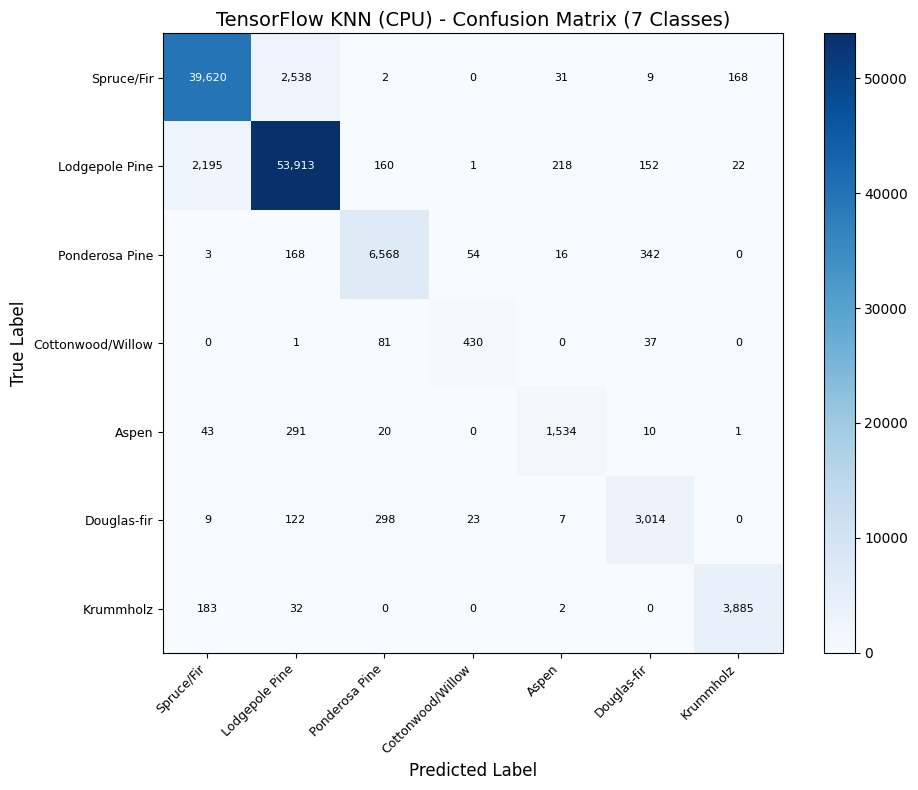

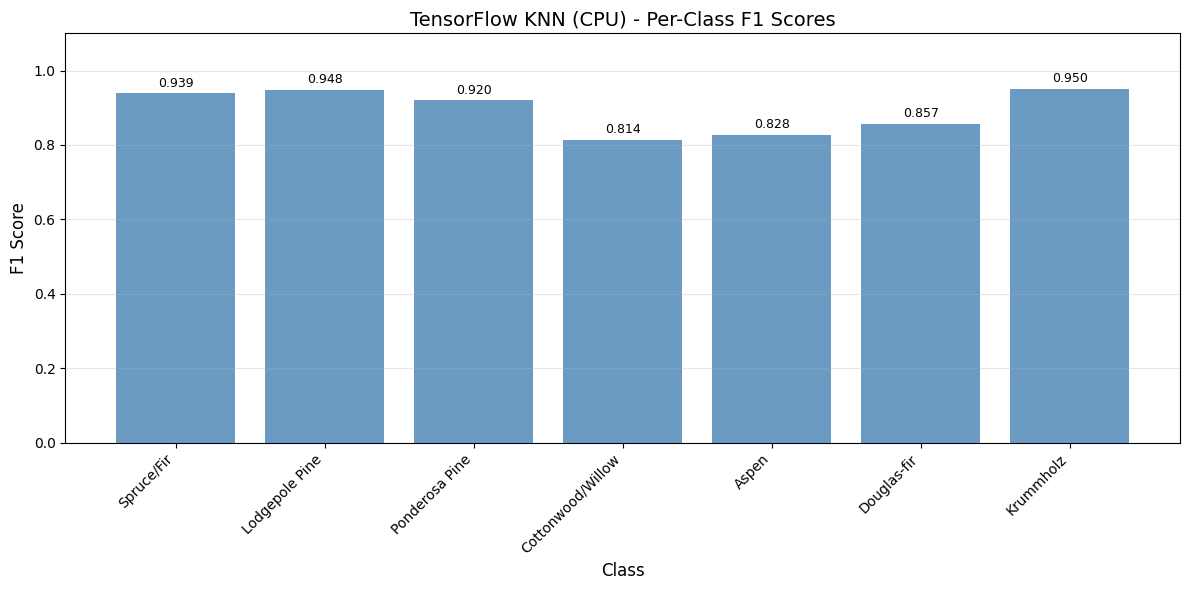

In [8]:
# Visualizations
"""
Generate the same visualizations as other frameworks for comparison:
    1. Confusion matrix
    2. Per-Class F1
"""

# Confusion Matrix
plot_confusion_matrix_multiclass(
    y_true=y_test,
    y_pred=y_pred,
    class_names=class_names,
    framework='TensorFlow KNN (CPU)',
    save_path='results/confusion_matrix.png'
)

# Per-Class F1 Scores
plot_per_class_f1(
    y_true=y_test,
    y_pred=y_pred,
    class_names=class_names,
    framework='TensorFlow KNN (CPU)',
    save_path='results/per_class_f1.png'
)